<a href="https://colab.research.google.com/github/NehaSontakk/BATH-Prokka-Comparison/blob/main/pHMMER_prokka_predicted_to_prodigal_ORF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
BATH_Prokka_aligned_annotations = "/content/drive/MyDrive/Lab Work/Parkinsons_Data/BIN152/Aligned Outputs/Aligned_Outputs_bin152.xlsx"
BATH_dedup_output = "/content/drive/MyDrive/Lab Work/Parkinsons_Data/BIN152/Deduplication Output/BATH_proteins_bin152.xlsx"
faa_file_path = '/content/drive/MyDrive/Lab Work/Parkinsons_Data/BIN152/Prokka Output/bin152.faa'

In [16]:
!pip install biopython
!sudo apt-get update
!sudo apt-get install hmmer

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy Release
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,422 kB]
Get:14 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,396 kB]
Fetched 4,074 kB in 2s (1,665 kB/s)
Re

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
from Bio import SeqIO
import re
import os
from io import StringIO
import subprocess

## Align Prokka proteins to Prodigal ORF lengths and compare these alginment lengths to BATH alignment lengths

Load files and extract information

In [18]:
df = pd.read_excel(BATH_Prokka_aligned_annotations)

bath_protein = pd.read_excel(BATH_dedup_output)
unnamed_cols = [col for col in bath_protein.columns if col.startswith('Unnamed')]
bath_protein.drop(columns=unnamed_cols, inplace=True)

#Extract the information for each row of information from both BATH and Prokka files
def extract_info(row):
    if pd.notnull(row['BATH']):
        bath_data = re.split(r'\t|\s+', str(row['BATH']))
        #print(bath_data)
        row['BATH_contig'] = bath_data[0]
        if len(bath_data) >= 3:
            row['BATH_annot'] = bath_data[-3]
            if int(bath_data[1]) < int(bath_data[2]):
              row['BATH_start'] = abs(int(bath_data[1]))
              row['BATH_end'] = abs(int(bath_data[2]))
            else:
              row['BATH_end'] = abs(int(bath_data[1]))
              row['BATH_start'] = abs(int(bath_data[2]))
        else:
            row['BATH_annot'] = None

    if pd.notnull(row['Prokka']):
        prokka_data = re.split(r'\t|\s+', str(row['Prokka']))
        prokka_annotr = re.split(r':', str(row['Prokka']))[-1]
        row['Prokka_contig'] = prokka_data[0]
        if len(prokka_data) >= 3:
            #print("Prokka starts:",int(prokka_data[1]))
            row['Prokka_annot'] = prokka_annotr
            if int(prokka_data[1]) < int(prokka_data[2]):
              row['Prokka_start'] = abs(int(prokka_data[1]))
              row['Prokka_end'] = abs(int(prokka_data[2]))
            else:
              row['Prokka_end'] = abs(int(prokka_data[1]) )
              row['Prokka_start'] = abs(int(prokka_data[2]))
        else:
            row['Prokka_annot'] = None
    return row

df = df.apply(extract_info, axis=1)
df = pd.merge(df,bath_protein[['target name','query name','E-value','shifts']],how="left",left_on=['BATH_contig','BATH_annot'],right_on=['target name','query name'])
df['Prokka_annot'] = df['Prokka_annot'].str.replace("002006", "", regex=False)
df['Prokka_annot'].replace("", np.nan, inplace=True)

Initializes a new column in the DataFrame to store amino acid sequences, defines a function to parse sequences from a .faa file

In [19]:
# Initialize a new column for the sequences
df['Prodigal ORF Amino'] = None

# Function to parse the .faa file and create a dictionary of sequences
def parse_faa_file(filepath):
    sequence_dict = {}
    for record in SeqIO.parse(filepath, "fasta"):
        sequence_dict[record.id] = str(record.seq)
    return sequence_dict

sequences = parse_faa_file(faa_file_path)

for index, row in df.iterrows():
    if pd.isna(row['Prokka']):  # Checking for NaN in 'Prokka' directly
        continue  # Skip this iteration if 'Prokka' is NaN

    try:
        parts = row['Prokka'].split('\t')
        gene_id = parts[3]  # Assuming the ID is in the fourth position
        if gene_id in sequences:
            df.loc[index, 'Prodigal ORF Amino'] = sequences[gene_id]
        else:
            print(f"Gene ID {gene_id} not found in .faa file.")
    except IndexError:
        print(f"Invalid data format in row {index}: {row['Prokka']}")

# Output the modified DataFrame
print(df)

                                           BATH BATH_annot   BATH_contig  \
0                                           NaN        NaN           NaN   
1                                           NaN        NaN           NaN   
2                                           NaN        NaN           NaN   
3                                           NaN        NaN           NaN   
4                                           NaN        NaN           NaN   
..                                          ...        ...           ...   
402  k127_2982141\t11286\t12548\tMF_00138\t+\t0   MF_00138  k127_2982141   
403    k127_2982141\t12931\t13911\tA3DDX7\t+\t0     A3DDX7  k127_2982141   
404    k127_2982141\t15010\t15252\tQ2FZD2\t+\t0     Q2FZD2  k127_2982141   
405  k127_2982141\t16989\t17780\tMF_00228\t+\t0   MF_00228  k127_2982141   
406  k127_2982141\t17781\t18393\tMF_00097\t+\t0   MF_00097  k127_2982141   

     BATH_end  BATH_start                                             Prokka  \
0      

fetching a Hidden Markov Model (HMM) profile for a specific protein from a database and then extracting the alignment length from the fetched HMM file.

In [20]:
def fetch_hmm_path(protein_name, hmm_db_path):
    # Define paths for output
    hmm_output_path = f"/content/output_{protein_name}.hmm"
    bhmm_output_path = f"/content/{protein_name}.bhmm"

    # Fetch command to retrieve the HMM profile for the given protein name
    fetch_command = f"hmmfetch -o '{hmm_output_path}' '{hmm_db_path}' '{protein_name}'"

    # Execute the command
    fetch_status = os.system(fetch_command)

    # Check if the fetch was successful
    if fetch_status != 0:
        print(f"Failed to fetch HMM for {protein_name}")
        return None

    # For now, let's just return the path to the fetched HMM
    return hmm_output_path

def get_hmm_alignment_length(hmm_path):
    with open(hmm_path, 'r') as file:
        for line in file:
            if line.startswith("LENG"):
                length = int(line.split()[1])
                return length
    return None

hmm_db_path = "/content/drive/MyDrive/Lab Work/Parkinsons_Data/Prokka db/hmm/HAMAP.hmm"
protein_name = "MF_01485"
hmm_path = fetch_hmm_path(protein_name, hmm_db_path)
if hmm_path:
    print(f"HMM file fetched at: {hmm_path}")
else:
    print("HMM fetching failed.")

if hmm_path:
    length = get_hmm_alignment_length(hmm_path)
    if length is not None:
        print(f"The length of the HMM alignment is: {length}")
    else:
        print("Failed to retrieve the HMM alignment length.")
else:
    print("HMM fetching failed.")

HMM file fetched at: /content/output_MF_01485.hmm
The length of the HMM alignment is: 1205


This additional part of the script defines a function process_protein to process each row in a DataFrame, fetch the HMM profile for a protein, and extract the alignment length.

In [21]:
def process_protein(row, hmm_db_path):
    protein_name = row['Prokka_annot']
    if pd.isna(protein_name) or not protein_name.startswith('MF_'):
        return pd.Series([None, None], index=['HMM_Alignment_Length', 'Protein_HMM_filepath'])

    # Fetch the HMM file path
    hmm_path = fetch_hmm_path(protein_name, hmm_db_path)
    if not hmm_path:
        return pd.Series([None, None], index=['HMM_Alignment_Length', 'Protein_HMM_filepath'])

    # Get the alignment length from the HMM file
    alignment_length = get_hmm_alignment_length(hmm_path)

    # Optionally remove the fetched HMM file (commented out for safety)
    # os.remove(hmm_path)

    # Return a Series with the alignment length and file path
    return pd.Series([alignment_length, hmm_path], index=['HMM_Alignment_Length', 'Protein_HMM_filepath'])

# Assuming df and hmm_db_path are defined elsewhere
df[['HMM_Alignment_Length', 'Protein_HMM_filepath']] = df.apply(process_protein, axis=1, args=(hmm_db_path,))

In [22]:
df['HMM_Alignment_Length'].dropna()

14     105.0
54     276.0
71     498.0
100    234.0
106    300.0
111    601.0
174    490.0
176    209.0
178    196.0
179    196.0
180    196.0
181    196.0
182    196.0
183    116.0
187    144.0
204    136.0
212    291.0
218    248.0
246    682.0
277    216.0
293    284.0
297    675.0
298    675.0
299    675.0
300    675.0
307    403.0
308    403.0
317    476.0
323    706.0
326    463.0
340    956.0
341    675.0
342    675.0
343    675.0
344    675.0
345    675.0
346    675.0
358    257.0
381    484.0
382    484.0
383    484.0
384    484.0
385    484.0
386    484.0
391    196.0
394    375.0
Name: HMM_Alignment_Length, dtype: float64

In [23]:
#This script processes a DataFrame to generate protein sequence files for each row where the protein name is valid, saves these files to a specified output directory
def generate_protein_files(row, output_dir):
    protein_name = row.get('Prokka_annot', None)

    # Check if protein name is valid
    if pd.isna(protein_name) or not protein_name.startswith('MF_'):
        print(f"Invalid or missing protein name: {protein_name}")
        return None

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Define file paths
    protein_sequence_path = os.path.join(output_dir, f"{protein_name}.fa")

    # Write the protein sequence to a file
    with open(protein_sequence_path, 'w') as protein_file:
        protein_sequence = row.get('Prokka Uniprot Protein Sequence', '')
        protein_file.write(f">{protein_name}\n{protein_sequence}\n")

    print(f"Protein sequence file created for {protein_name} at {protein_sequence_path}")


    # You could return path or confirmation message
    return protein_sequence_path


output_dir = "/content/protein_files"  # Define the directory to store protein files
df_name = 'df'

if df_name in globals():
    result_column_name = 'Protein_FA_File_Status'
    globals()[df_name][result_column_name] = globals()[df_name].apply(generate_protein_files, axis=1, args=(output_dir,))
    print(globals()[df_name])
else:
    print(f"DataFrame {df_name} does not exist.")

df['Protein_FA_File_Path'] = df.apply(generate_protein_files, axis=1, args=(output_dir,))

print(df)

Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein name: P0AGK4
Invalid or missing protein name: nan
Protein sequence file created for MF_02014 at /content/protein_files/MF_02014.fa
Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein name: nan
Invalid or missing protein n


This script reads multiple FASTA files, combines their sequences into a single FASTA file, and then extracts specific protein sequences based on a DataFrame column.

In [24]:
file_paths = [
    "/content/drive/MyDrive/Lab Work/Parkinsons_Data/Prokka db/kingdom/Bacteria/sprot",
    "/content/drive/MyDrive/Lab Work/Parkinsons_Data/Prokka db/kingdom/Bacteria/IS",
    "/content/drive/MyDrive/Lab Work/Parkinsons_Data/Prokka db/kingdom/Bacteria/AMR",
    "/content/drive/MyDrive/Lab Work/Parkinsons_Data/Prokka db/kingdom/Archaea/sprot",
    "/content/drive/MyDrive/Lab Work/Parkinsons_Data/Prokka db/kingdom/Mitochondria/sprot",
    "/content/drive/MyDrive/Lab Work/Parkinsons_Data/Prokka db/kingdom/Viruses/sprot"
]
combined_file = "/content/drive/MyDrive/Lab Work/Parkinsons_Data/combined_sequences.fasta"

with open(combined_file, 'w') as combined_fasta:
    for file_path in file_paths:
        if os.path.exists(file_path):
            for record in SeqIO.parse(file_path, "fasta"):
                SeqIO.write(record, combined_fasta, "fasta")
        else:
            print(f"File not found: {file_path}")


def get_fasta_entries(fasta_path, protein_name):
    #print(protein_name)
    if pd.isna(protein_name):
          return None
    for record in SeqIO.parse(fasta_path, "fasta"):
        if protein_name == record.name:
          #print(record.seq)
          return str(record.seq)

def get_prokka_fasta_sequence(row):
    return get_fasta_entries(combined_file, row['Prokka_annot'])


df['Prokka Uniprot Protein Sequence'] = df.apply(get_prokka_fasta_sequence,axis=1)
df[~df['Prokka_annot'].isna()]['Prokka Uniprot Protein Sequence']

12     MNLSTKQKQHLKGLAHPLKPVVLLGSNGLTEGVLAEIEQALEHHEL...
14                                                  None
54                                                  None
71                                                  None
80     MKKSLLAVMLTGLFALVSLPALGNVNLEQLKQKAESGEAKAQLELG...
                             ...                        
401    MKKAILSVSNKTGIVEFAKALTQLNYELYSTGGTKRILDEANVPVR...
402    MNVLIIGKGGREHTLAWKAAQSSLVENVFAAPGNDGMAASAQLVNI...
403    MGGVTLEKIRIGIVGYGNLGKGAELGIRQNKDMELVGIFTRRNPNS...
405    MDAQSAAKCLTAVRRHSPLVHSITNNVVTNFTANGLLALGASPVMA...
406    MTRISREMMKELLSVYFIMGSNNTKADPVTVVQKALKGGATLYQFR...
Name: Prokka Uniprot Protein Sequence, Length: 302, dtype: object

In [25]:
df[['Prodigal ORF Amino','Prokka Uniprot Protein Sequence']]

,Prodigal ORF Amino,Prokka Uniprot Protein Sequence
0,MAEEKRVNLKAKKFEAYIQKNNMNFFNKNEVHDEADTVVFQSNIKV...,None
1,MKRLASVFLFLLMAALAFFGILRFARQQAEVKAEKMNPSEYVTVYT...,None
2,MTDKKEDPIIITITGPDGDERDYVQDTVIPFAGKEFAVLVSIPEKE...,None
3,MNTEKTVSAGRKKKKLHIEFLRALCIWLVMFTHTSTAGFSLYIERP...,None
4,MISPGSLFPADFRKSRGVGAVAPAYDNHHIYSIRQLTSRLLPLHGC...,None
...,...,...
402,MKVLVIGSGGREHALLWRLAQSPSVTEVYAIPGNDGMSNVAHLIPL...,MNVLIIGKGGREHTLAWKAAQSSLVENVFAAPGNDGMAASAQLVNI...
403,MAIRIGIMGYGNIGKGIETALADYPDMELAVVFTRRNPADVKIHTS...,MGGVTLEKIRIGIVGYGNLGKGAELGIRQNKDMELVGIFTRRNPNS...
404,MIAPITGTANIDKVLTEGDVILGFSAPWCGYCRRLRPMVEKLSGEI...,None
405,MELSEYLDRVRKLNPLVHHITNYVTVNDCANACLAVGASPVMADAI...,MDAQSAAKCLTAVRRHSPLVHSITNNVVTNFTANGLLALGASPVMA...


Code iterates through each row of a DataFrame, checks if specific columns contain non-null values, and performs a sequence alignment using the phmmer tool.

Sequence alignment is carried out between:

1.   Prodigal ORF Amino: This column contains the amino acid sequence of an Open Reading Frame (ORF) predicted by the Prodigal tool.
2.   Prokka Uniprot Protein Sequence: This column contains the protein sequence annotated by Prokka and sourced from their github database.

In [26]:
for index, row in df.iterrows():
    if pd.notna(row['Prodigal ORF Amino']) and pd.notna(row['Prokka Uniprot Protein Sequence']):
        df.at[index, 'Prodigal ORF Length'] = len(row['Prodigal ORF Amino'])
        query_seq = f">query_{index}\n{row['Prodigal ORF Amino']}"
        db_seq = f">db_{index}\n{row['Prokka Uniprot Protein Sequence']}"

        with open(f"query_{index}.fasta", 'w') as file:
            file.write(query_seq)
        with open(f"db_{index}.fasta", 'w') as file:
            file.write(db_seq)

        # Run phxmmer
        result = subprocess.run(['phmmer', f"query_{index}.fasta", f"db_{index}.fasta"], capture_output=True, text=True)

        # Extract E-value
        e_value_pattern = r"conditional E-value:\s*([0-9\.e\-]+)"
        e_value_match = re.search(e_value_pattern, result.stdout)
        if e_value_match:
            e_value = e_value_match.group(1)
            df.at[index, 'Prokka ORF phmmer E-value'] = e_value

        output_lines = result.stdout.split('\n')
        # Access line 22
        if len(output_lines) > 21:
            line_22 = output_lines[21]
            parts = line_22.split()
            cleaned_parts = [re.sub(r"[^\d.eE\-]", "", part.replace('..', '')) for part in parts]
            if len(cleaned_parts) >= 11:  # Ensure the list has enough elements
                df.at[index, 'Prokka ORF phmmer ali from'] = int(cleaned_parts[9])
                df.at[index, 'Prokka ORF phmmer ali to'] = int(cleaned_parts[10])
                df.at[index, 'Prokka ORF phmmer length'] = abs(int(cleaned_parts[10]) - int(cleaned_parts[9]))

    else:
        print(f"Skipping Row {index} due to None value.")

Skipping Row 0 due to None value.
Skipping Row 1 due to None value.
Skipping Row 2 due to None value.
Skipping Row 3 due to None value.
Skipping Row 4 due to None value.
Skipping Row 5 due to None value.
Skipping Row 6 due to None value.
Skipping Row 7 due to None value.
Skipping Row 8 due to None value.
Skipping Row 9 due to None value.
Skipping Row 10 due to None value.
Skipping Row 11 due to None value.
Skipping Row 13 due to None value.
Skipping Row 14 due to None value.
Skipping Row 15 due to None value.
Skipping Row 16 due to None value.
Skipping Row 17 due to None value.
Skipping Row 18 due to None value.
Skipping Row 19 due to None value.
Skipping Row 20 due to None value.
Skipping Row 21 due to None value.
Skipping Row 22 due to None value.
Skipping Row 23 due to None value.
Skipping Row 24 due to None value.
Skipping Row 25 due to None value.
Skipping Row 26 due to None value.
Skipping Row 27 due to None value.
Skipping Row 28 due to None value.
Skipping Row 29 due to None va

Sequence alignment here performed between the Prodigal ORF Amino sequences and the HMM profiles specified in HAMAP filepath.

In [27]:
for index, row in df.iterrows():
    if pd.notna(row['Prodigal ORF Amino']) and pd.notna(row['Protein_HMM_filepath']):
        query_seq = f">query_{index}\n{row['Prodigal ORF Amino']}"
        output_tbl_file = os.path.join(output_dir, f"results_{index}.txt")
        print(row['Protein_HMM_filepath'])

        with open(f"query_{index}.fasta", 'w') as file:
            file.write(query_seq)

        result = subprocess.run(['hmmsearch', row['Protein_HMM_filepath'], f'query_{index}.fasta'], capture_output=True, text=True)

        if result.returncode != 0:
            print(f"Error running hmmsearch for query {index}: {result.stderr}")
            continue

        #print("Standard Output:", result.stdout)
        output_lines = result.stdout.split('\n')
        #print(output_lines)
        if len(output_lines) > 2:
          line_12 = output_lines[15]
          parts = line_12.split()
          #cleaned_parts = [re.sub(r"[^\d.eE\-]", "", part.replace('..', '')) for part in parts]
          e_value = parts[3]
          df.at[index, 'Prokka ORF HMM phmmer E-value'] = e_value

        # Access line 22
        if len(output_lines) > 21:
            line_ali = output_lines[22]
            parts = line_ali.split()
            #print(parts)
            cleaned_parts = [re.sub(r"[^\d.eE\-]", "", part.replace('..', '')) for part in parts]
            if len(cleaned_parts) >= 11:  # Ensure the list has enough elements
                df.at[index, 'Prokka ORF HMM phmmer ali from'] = int(cleaned_parts[9])
                #print(int(cleaned_parts[9]))
                df.at[index, 'Prokka ORF HMM phmmer ali to'] = int(cleaned_parts[10])
                df.at[index, 'Prokka ORF HMM phmmer length'] = abs(int(cleaned_parts[10]) - int(cleaned_parts[9]))

    else:
        print(f"Skipping Row {index} due to None value.")

Skipping Row 0 due to None value.
Skipping Row 1 due to None value.
Skipping Row 2 due to None value.
Skipping Row 3 due to None value.
Skipping Row 4 due to None value.
Skipping Row 5 due to None value.
Skipping Row 6 due to None value.
Skipping Row 7 due to None value.
Skipping Row 8 due to None value.
Skipping Row 9 due to None value.
Skipping Row 10 due to None value.
Skipping Row 11 due to None value.
Skipping Row 12 due to None value.
Skipping Row 13 due to None value.
/content/output_MF_02014.hmm
Skipping Row 15 due to None value.
Skipping Row 16 due to None value.
Skipping Row 17 due to None value.
Skipping Row 18 due to None value.
Skipping Row 19 due to None value.
Skipping Row 20 due to None value.
Skipping Row 21 due to None value.
Skipping Row 22 due to None value.
Skipping Row 23 due to None value.
Skipping Row 24 due to None value.
Skipping Row 25 due to None value.
Skipping Row 26 due to None value.
Skipping Row 27 due to None value.
Skipping Row 28 due to None value.
S

Sum the values from the columns Prokka ORF phmmer length and Prokka ORF HMM phmmer length.

In [28]:
df['Merged_Column'] = df['Prokka ORF phmmer length'].fillna(0).astype(int) + df['Prokka ORF HMM phmmer length'].fillna(0).astype(int)
df['Merged_Column'] = pd.to_numeric(df['Merged_Column'], errors='coerce')

A column to store the softwares used by prokka to annotate

In [29]:
def parse_prokka(row):
    if pd.isna(row):
        return np.nan

    parts = row.split('\t')
    last_element = parts[-1]

    if 'UniProt' in last_element:
        return 'Blast'
    elif 'IS' in last_element:
        return 'ISFinder'
    elif 'MF' in last_element:
        return 'HMMER'
    else:
        return 'Prodigal'

# Apply the function to the 'Prokka' column and create the new 'Prokka_SW' column
df['Prokka_SW'] = df['Prokka'].apply(parse_prokka)

print(df['Prokka_SW'].value_counts())

Prokka_SW
Blast       256
Prodigal    102
HMMER        46
Name: count, dtype: int64


In [35]:
df.columns

Index(['BATH', 'BATH_annot', 'BATH_contig', 'BATH_end', 'BATH_start', 'Prokka',
       'Prokka_annot', 'Prokka_contig', 'Prokka_end', 'Prokka_start', 'label',
       'target name', 'query name', 'E-value', 'shifts', 'Prodigal ORF Amino',
       'HMM_Alignment_Length', 'Protein_HMM_filepath',
       'Protein_FA_File_Status', 'Protein_FA_File_Path',
       'Prokka Uniprot Protein Sequence', 'Prodigal ORF Length',
       'Prokka ORF phmmer E-value', 'Prokka ORF phmmer ali from',
       'Prokka ORF phmmer ali to', 'Prokka ORF phmmer length',
       'Prokka ORF HMM phmmer E-value', 'Prokka ORF HMM phmmer ali from',
       'Prokka ORF HMM phmmer ali to', 'Prokka ORF HMM phmmer length',
       'Merged_Column', 'Prokka_SW'],
      dtype='object')

In [34]:
df

,BATH,BATH_annot,BATH_contig,BATH_end,BATH_start,Prokka,Prokka_annot,Prokka_contig,Prokka_end,Prokka_start,...,Prokka ORF phmmer E-value,Prokka ORF phmmer ali from,Prokka ORF phmmer ali to,Prokka ORF phmmer length,Prokka ORF HMM phmmer E-value,Prokka ORF HMM phmmer ali from,Prokka ORF HMM phmmer ali to,Prokka ORF HMM phmmer length,Merged_Column,Prokka_SW
0,NaN,NaN,NaN,NaN,NaN,k127_1510713\t34819\t35265\tJNLINIBG_00529\t+\...,NaN,k127_1510713,35265.0,34819.0,...,nan,NaN,NaN,NaN,nan,NaN,NaN,NaN,0,Prodigal
1,NaN,NaN,NaN,NaN,NaN,k127_1510713\t50219\t51262\tJNLINIBG_00540\t+\...,NaN,k127_1510713,51262.0,50219.0,...,nan,NaN,NaN,NaN,nan,NaN,NaN,NaN,0,Prodigal
2,NaN,NaN,NaN,NaN,NaN,k127_1510713\t67321\t67584\tJNLINIBG_00555\t+\...,NaN,k127_1510713,67584.0,67321.0,...,nan,NaN,NaN,NaN,nan,NaN,NaN,NaN,0,Prodigal
3,NaN,NaN,NaN,NaN,NaN,k127_1510713\t72880\t73986\tJNLINIBG_00558\t+\...,NaN,k127_1510713,73986.0,72880.0,...,nan,NaN,NaN,NaN,nan,NaN,NaN,NaN,0,Prodigal
4,NaN,NaN,NaN,NaN,NaN,k127_1032292\t172\t390\tJNLINIBG_00094\t+\tab ...,NaN,k127_1032292,390.0,172.0,...,nan,NaN,NaN,NaN,nan,NaN,NaN,NaN,0,Prodigal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,k127_2982141\t11286\t12548\tMF_00138\t+\t0,MF_00138,k127_2982141,12548.0,11286.0,k127_2982141\t11286\t12566\tJNLINIBG_00635\t+\...,P12039,k127_2982141,12566.0,11286.0,...,4.4e-141,1.0,418.0,417.0,nan,NaN,NaN,NaN,417,Blast
403,k127_2982141\t12931\t13911\tA3DDX7\t+\t0,A3DDX7,k127_2982141,13911.0,12931.0,k127_2982141\t12928\t13914\tJNLINIBG_00636\t+\...,A3DDX7,k127_2982141,13914.0,12928.0,...,6.5e-142,9.0,334.0,325.0,nan,NaN,NaN,NaN,325,Blast
404,k127_2982141\t15010\t15252\tQ2FZD2\t+\t0,Q2FZD2,k127_2982141,15252.0,15010.0,k127_2982141\t14989\t15306\tJNLINIBG_00638\t+\...,NaN,k127_2982141,15306.0,14989.0,...,nan,NaN,NaN,NaN,nan,NaN,NaN,NaN,0,Prodigal
405,k127_2982141\t16989\t17780\tMF_00228\t+\t0,MF_00228,k127_2982141,17780.0,16989.0,k127_2982141\t16983\t17789\tJNLINIBG_00640\t+\...,P39593,k127_2982141,17789.0,16983.0,...,2.4e-62,8.0,264.0,256.0,nan,NaN,NaN,NaN,256,Blast


## Vizualisations

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
df['Prodigal Amino Length'] = df['Prodigal ORF Amino'].str.len()

In [37]:
df['Prokka ORF HMM phmmer length'].fillna(0,inplace=True)
df['Prodigal Amino Length'].fillna(0,inplace=True)

### 1. Comparison of Prodigal ORF Lengths with Prokka Annotation Lengths

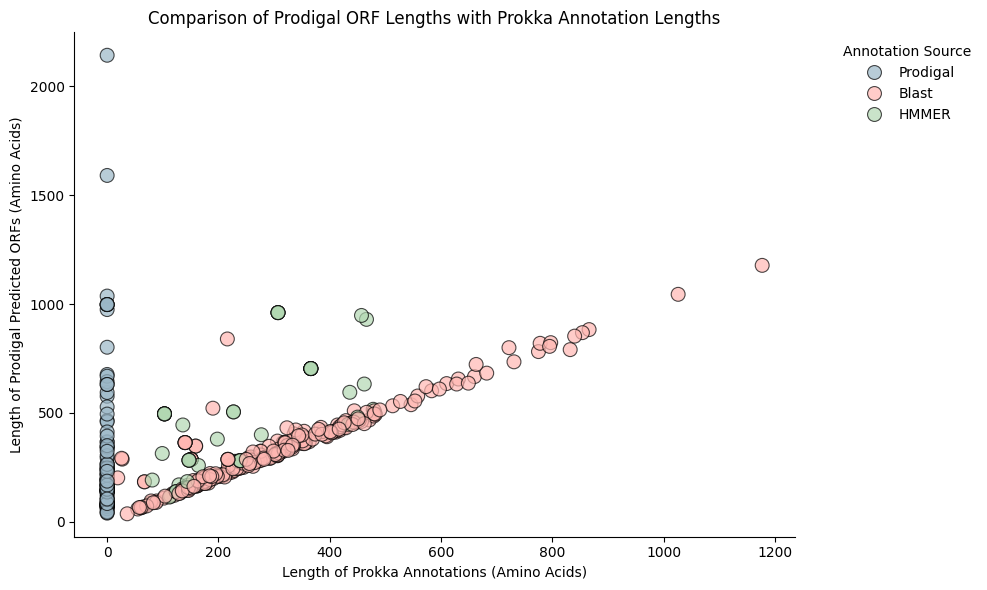

In [41]:
# Define the color palette ensuring all categories have valid colors
palette2 = {
    'Blast': '#FFB7B2',
    'ISFinder': '#FDE293',
    'HMMER': '#B2D8B2',
    'Prodigal': '#9BB7C7'
}

# Create the plot
plt.figure(figsize=(10, 6))
try:
    ax = sns.scatterplot(
        y='Prodigal Amino Length',
        x='Merged_Column',
        hue='Prokka_SW',
        data=df,
        palette=palette2,
        s=100,
        alpha=0.7,
        edgecolor='black'
    )
    plt.title('Comparison of Prodigal ORF Lengths with Prokka Annotation Lengths')
    plt.ylabel('Length of Prodigal Predicted ORFs (Amino Acids)')
    plt.xlabel('Length of Prokka Annotations (Amino Acids)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(title='Annotation Source', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Error during plotting:", e)



### 2. Comparing BATH Amino lengths to Prodigal Amino Lengths

Multiplying the Prokka amino acid lengths to mark DNA alignment lengths for BATH

In [42]:
df['Prokka_BATH_3Mult'] = df['Merged_Column']*3
df['Prodigal Amino Length BATH'] = df['Prodigal Amino Length']*3

In [43]:
def calculate_length_and_contig(annotation):
    if pd.isna(annotation):
        return None, None
    parts = annotation.split('\t')
    contig = parts[0]
    start = int(parts[1])
    end = int(parts[2])
    length = abs(end - start)
    return length, contig

# Apply the function to the BATH column
df[['BATH_length', 'contig_bath']] = df['BATH'].apply(lambda x: pd.Series(calculate_length_and_contig(x)))

In [44]:
df['BATH_length'].fillna(0,inplace=True)
df['shifts'].fillna(0,inplace=True)

In [45]:
df[['BATH_length','Prodigal Amino Length BATH','shifts']]

,BATH_length,Prodigal Amino Length BATH,shifts
0,0.0,444.0,0.0
1,0.0,1041.0,0.0
2,0.0,261.0,0.0
3,0.0,1104.0,0.0
4,0.0,216.0,0.0
...,...,...,...
402,1262.0,1278.0,0.0
403,980.0,984.0,0.0
404,242.0,315.0,0.0
405,791.0,804.0,0.0


In [46]:
df['BATH_length'] = abs(df['BATH_end']- df['BATH_start'])

<ipython-input-52-9fb02b53754d>:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='Frameshift Count', orientation='vertical')


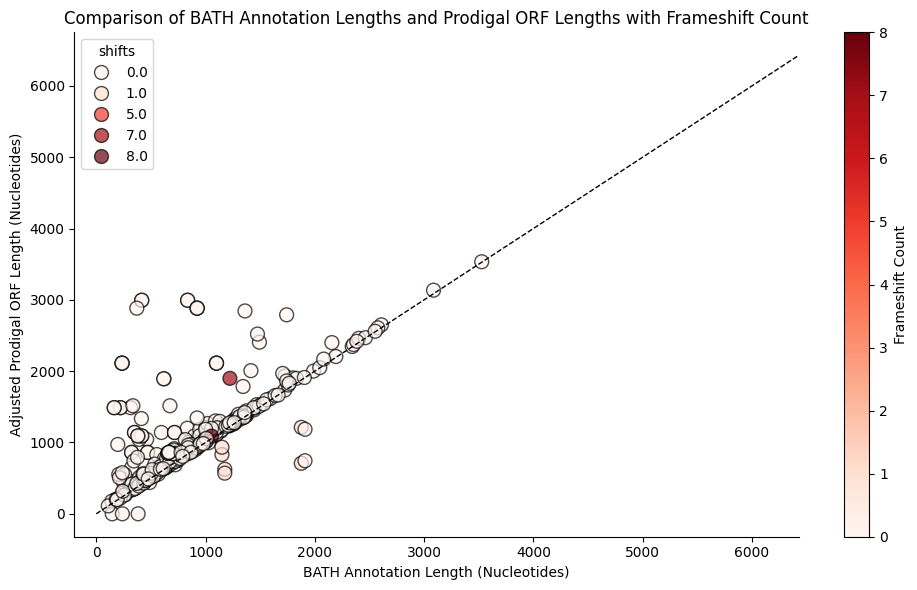

In [52]:
cmap = sns.color_palette("Reds", as_cmap=True)

# Plot the data, ignoring NaNs in 'shifts' for the color mapping
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x='BATH_length',
    y='Prodigal Amino Length BATH',
    hue='shifts',
    data=df,
    palette=cmap,
    s=100,
    alpha=0.7,
    edgecolor='black',
    linewidth=1
)

# Plot the 45-degree line
max_length = max(df['Prodigal Amino Length BATH'].max(), df['BATH_length'].max())
plt.plot([0, max_length], [0, max_length], color='black', linestyle='--', linewidth=1)

# Set title and labels
plt.title('Comparison of BATH Annotation Lengths and Prodigal ORF Lengths with Frameshift Count')
plt.ylabel('Adjusted Prodigal ORF Length (Nucleotides)')
plt.xlabel('BATH Annotation Length (Nucleotides)')
plt.xlim(-200, max_length)

# Add a colorbar
norm = plt.Normalize(df['shifts'].min(), df['shifts'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, label='Frameshift Count', orientation='vertical')

# Customize plot appearance
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("Fig6_lengthBATHProdigal.svg", dpi=300, transparent=True, bbox_inches='tight')
plt.show()

## 3. Comparing Prokka Alignments lengths to BATH Lengths

<ipython-input-57-9e7ebffeb7b9>:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='Frameshift Count', orientation='vertical')


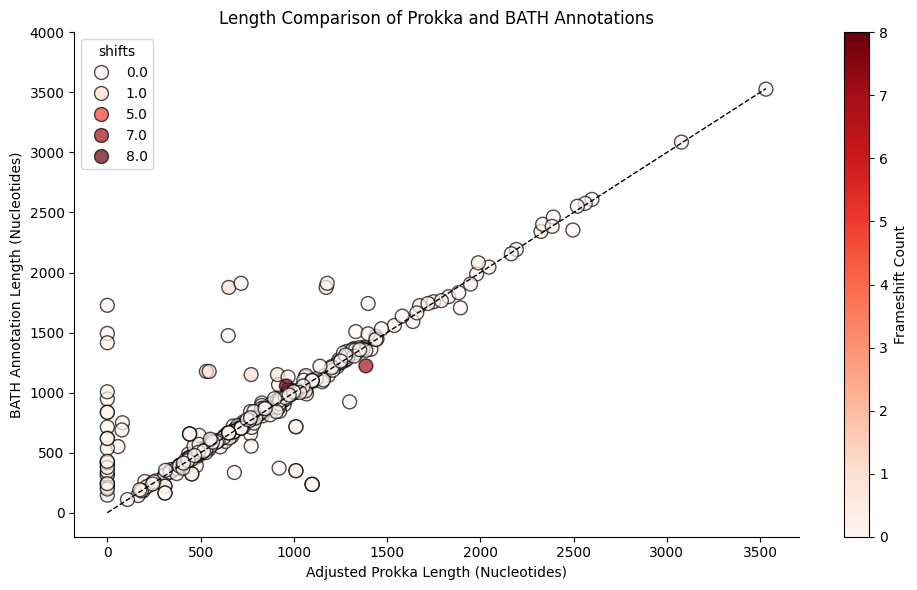

In [57]:
cmap = sns.color_palette("Reds", as_cmap=True)

# Plot the data, ignoring NaNs in 'shifts' for the color mapping
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x='Prokka_BATH_3Mult',  # Flipped x and y
    y='BATH_length',        # Flipped x and y
    hue='shifts',
    data=df,
    palette=cmap,
    s=100,
    alpha=0.7,
    edgecolor='black',
    linewidth=1
)

# Plot the 45-degree line
max_length = max(df['Prokka_BATH_3Mult'].max(), df['BATH_length'].max())
plt.plot([0, max_length], [0, max_length], color='black', linestyle='--', linewidth=1)

# Set title and labels
plt.title('Length Comparison of Prokka and BATH Annotations')
plt.xlabel('Adjusted Prokka Length (Nucleotides)')
plt.ylabel('BATH Annotation Length (Nucleotides)')
plt.ylim(-200, 4000)

# Add a colorbar
norm = plt.Normalize(df['shifts'].min(), df['shifts'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, label='Frameshift Count', orientation='vertical')

# Customize plot appearance
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("zFig6_lengthBATHProdigal.svg", dpi=300, transparent=True, bbox_inches='tight')
plt.show()

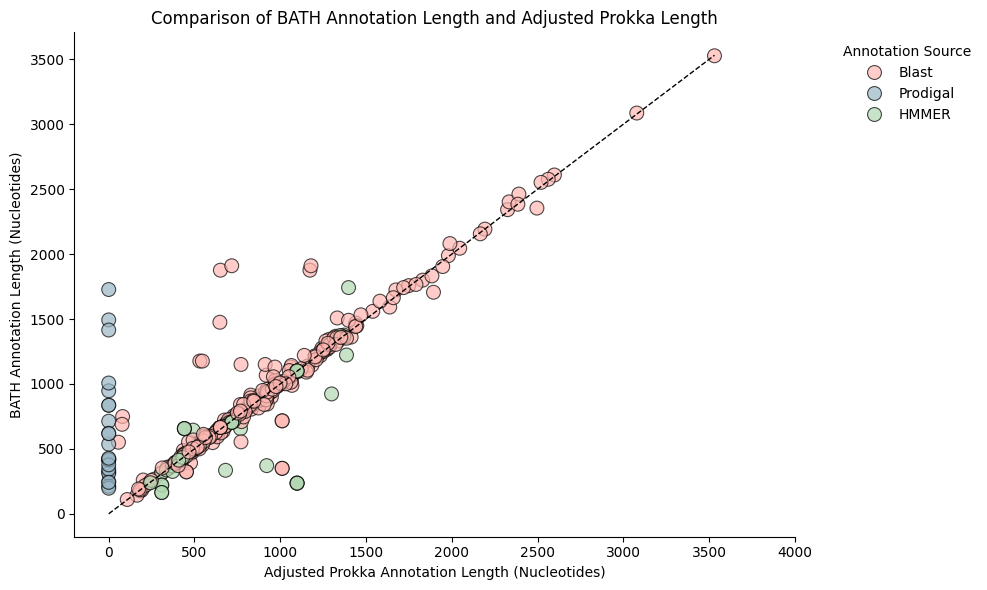

In [59]:
filtered_data = df.dropna(subset=['Prokka_BATH_3Mult', 'BATH_length'])

# Define the pastel palette with the requested colors
palette2 = {
    'Blast': '#FFB7B2',
    'ISFinder': '#FDE293',
    'HMMER': '#B2D8B2',
    'Prodigal': '#9BB7C7'
}

# Plot the data
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    x='Prokka_BATH_3Mult',  # X-axis represents Prokka
    y='BATH_length',        # Y-axis represents BATH
    hue='Prokka_SW',
    data=filtered_data,
    palette=palette2,
    s=100,
    alpha=0.7,
    edgecolor='black'
)

# Plot the 45-degree line
max_length = max(filtered_data['BATH_length'].max(), filtered_data['Prokka_BATH_3Mult'].max())
plt.plot([0, max_length], [0, max_length], color='black', linestyle='--', linewidth=1)

# Set title and labels
plt.title('Comparison of BATH Annotation Length and Adjusted Prokka Length')
plt.xlabel('Adjusted Prokka Annotation Length (Nucleotides)')
plt.ylabel('BATH Annotation Length (Nucleotides)')
plt.xlim(-200, 4000)  # Adjusted based on the range of the data

# Customize legend and plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(title='Annotation Source', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.savefig("zFig5_lengthBATHProkka.svg", dpi=300, transparent=True, bbox_inches='tight')
plt.show()


## 6. Length comparisons of BATH, Prokka, Prodigal

<ipython-input-62-ab1429c34609>:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(custom_order, rotation=45, ha='right')


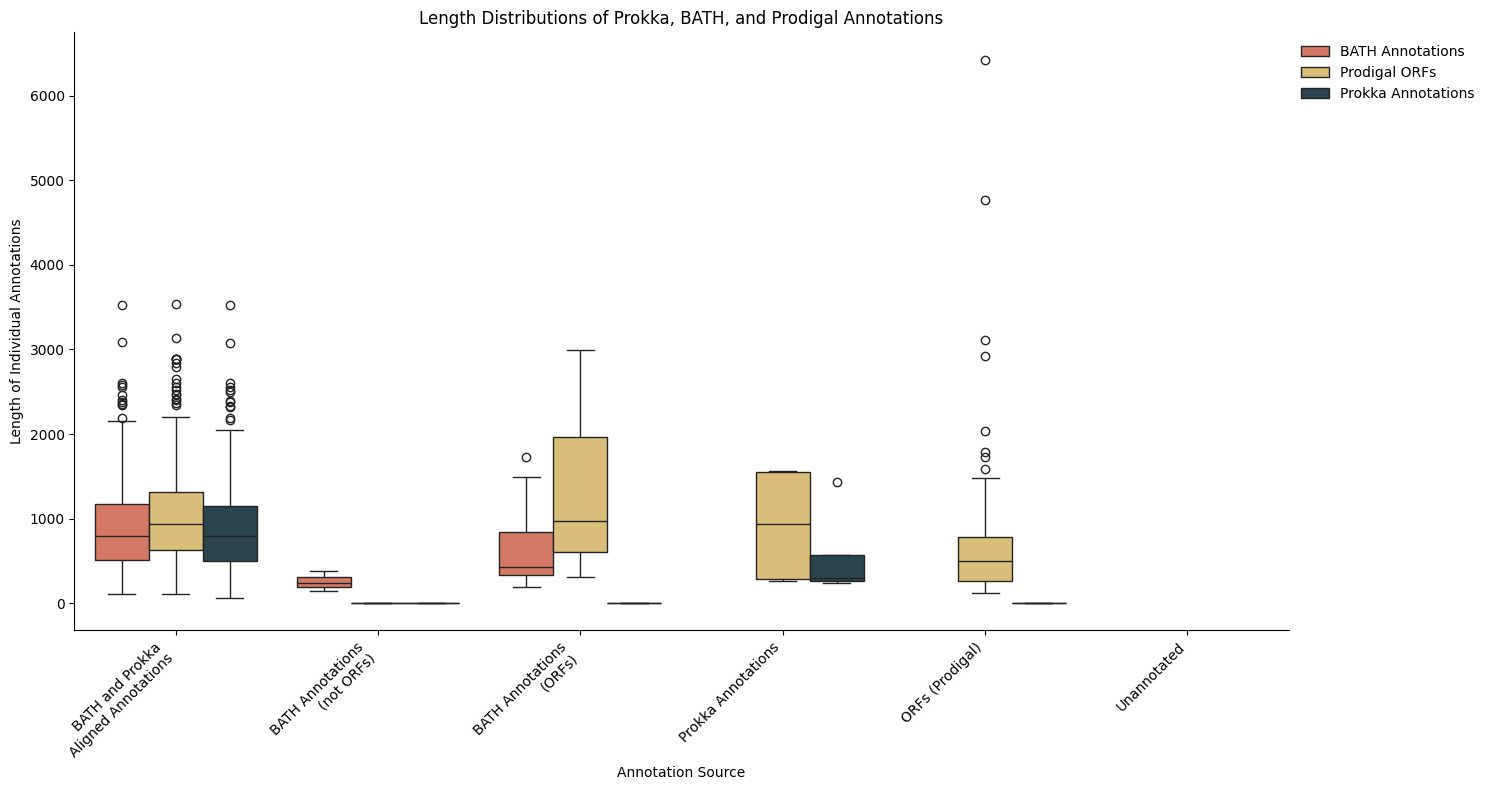

In [62]:
# Prepare the DataFrame for plotting
lengths = []
labels = []
annotations = []

# Populate the lists from the DataFrame
for _, row in df.iterrows():
    if pd.notna(row['Prokka_BATH_3Mult']):
        lengths.append(row['Prokka_BATH_3Mult'])
        labels.append(row['label'])
        annotations.append('Prokka')

    if pd.notna(row['BATH_length']):
        lengths.append(row['BATH_length'])
        labels.append(row['label'])
        annotations.append('BATH')

    if pd.notna(row['Prodigal Amino Length BATH']):
        lengths.append(row['Prodigal Amino Length BATH'])
        labels.append(row['label'])
        annotations.append('Prodigal ORF')

# Create a new DataFrame for plotting
plot_df = pd.DataFrame({
    'Length': lengths,
    'Label': labels,
    'Annotation': annotations
})

# Define custom order for the labels
custom_order = [
    'BATH and Prokka\nAligned Annotations',
    'BATH Annotations\n(not ORFs)',
    'BATH Annotations\n(ORFs)',
    'Prokka Annotations',
    'ORFs (Prodigal)',
    'Unannotated'
]

# Apply custom labels to the dataframe for plotting
custom_labels = {
    'BATH and Prokka Annotated': 'BATH and Prokka\nAligned Annotations',
    'Prokka Unannotated': 'ORFs (Prodigal)',
    'BATH and Prokka Unannotated': 'BATH Annotations\n(ORFs)',
    'BATH': 'BATH Annotations\n(not ORFs)',
    'Unannotated': 'Unannotated',
    'Prokka Annotated':'Prokka Annotations'
}

plot_df['Custom Label'] = plot_df['Label'].map(custom_labels)

# Sort the DataFrame by custom order
plot_df['Custom Label'] = pd.Categorical(plot_df['Custom Label'], categories=custom_order, ordered=True)
plot_df = plot_df.sort_values('Custom Label')

# Define the color palette
palette = {
    'Prokka': '#264653',
    'BATH': '#E76F51',
    'Prodigal ORF': '#E9C46A'
}

legend_labels = {
    'Prokka': 'Prokka Annotations',
    'BATH': 'BATH Annotations',
    'Prodigal ORF': 'Prodigal ORFs'
}

plt.style.use('default')
fig, ax = plt.subplots(figsize=(15, 8))

# Create the box plot
sns.boxplot(x='Custom Label', y='Length', hue='Annotation', data=plot_df, palette=palette, ax=ax, width=0.8)

# Customize the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_title('Length Distributions of Prokka, BATH, and Prodigal Annotations')
ax.set_xlabel('Annotation Source')
ax.set_ylabel('Length of Individual Annotations')
ax.set_xticklabels(custom_order, rotation=45, ha='right')

# Adjust the legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [legend_labels[label] for label in labels]
ax.legend(handles, new_labels, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
plt.savefig("zFig4_length_ORFBATHProkka.svg", dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [63]:
df.columns

Index(['BATH', 'BATH_annot', 'BATH_contig', 'BATH_end', 'BATH_start', 'Prokka',
       'Prokka_annot', 'Prokka_contig', 'Prokka_end', 'Prokka_start', 'label',
       'target name', 'query name', 'E-value', 'shifts', 'Prodigal ORF Amino',
       'HMM_Alignment_Length', 'Protein_HMM_filepath',
       'Protein_FA_File_Status', 'Protein_FA_File_Path',
       'Prokka Uniprot Protein Sequence', 'Prodigal ORF Length',
       'Prokka ORF phmmer E-value', 'Prokka ORF phmmer ali from',
       'Prokka ORF phmmer ali to', 'Prokka ORF phmmer length',
       'Prokka ORF HMM phmmer E-value', 'Prokka ORF HMM phmmer ali from',
       'Prokka ORF HMM phmmer ali to', 'Prokka ORF HMM phmmer length',
       'Merged_Column', 'Prokka_SW', 'Prodigal Amino Length',
       'Prokka_BATH_3Mult', 'Prodigal Amino Length BATH', 'BATH_length',
       'contig_bath'],
      dtype='object')

In [64]:
df[~df['Prodigal ORF Amino'].isna()].shape

(404, 37)

In [65]:
df['merge_evalue'] = df['Prokka ORF phmmer E-value'].fillna(df['Prokka ORF HMM phmmer E-value'])

<ipython-input-66-c97c47fc757c>:11: RuntimeWarning: divide by zero encountered in log10
  df['Log E-value'] = df['E-value'].apply(lambda x: np.log10(x) if pd.notnull(x) else np.nan)
<ipython-input-66-c97c47fc757c>:12: RuntimeWarning: divide by zero encountered in log10
  df['Adjusted Log merge_evalue'] = df['merge_evalue'].apply(lambda x: np.log10(x) if pd.notnull(x) else np.nan)


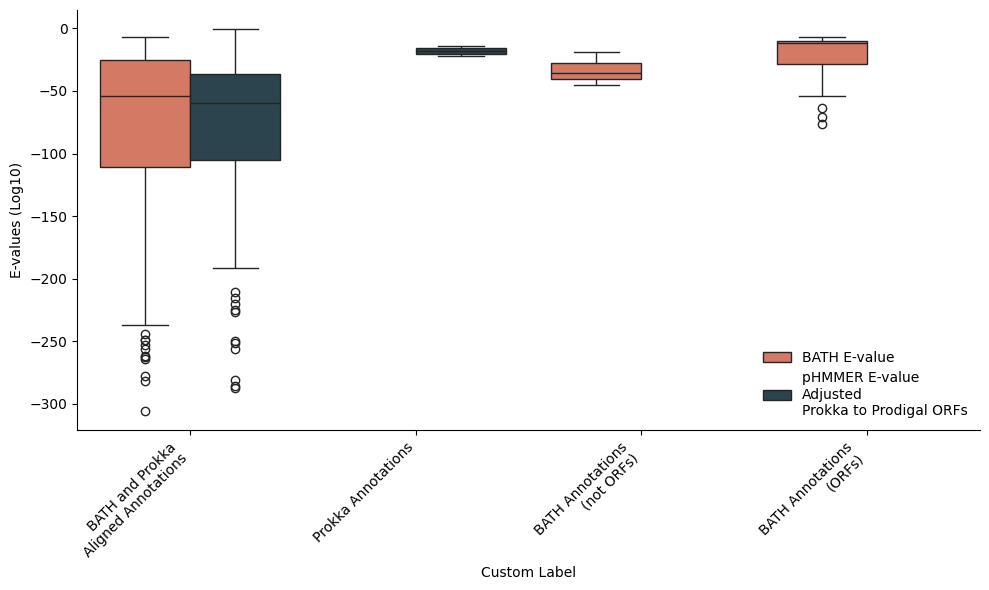

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert columns to numeric, setting errors='coerce' will convert non-convertible types to NaN
df['E-value'] = pd.to_numeric(df['E-value'], errors='coerce')
df['merge_evalue'] = pd.to_numeric(df['merge_evalue'], errors='coerce')
df['Adjusted merge_evalue'] = df['merge_evalue'] * 975

df['Log E-value'] = df['E-value'].apply(lambda x: np.log10(x) if pd.notnull(x) else np.nan)
df['Adjusted Log merge_evalue'] = df['merge_evalue'].apply(lambda x: np.log10(x) if pd.notnull(x) else np.nan)

custom_labels = {
    'BATH and Prokka Annotated': 'BATH and Prokka\nAligned Annotations',
    'Prokka Unannotated': 'ORFs (Prodigal)',
    'BATH and Prokka Unannotated': 'BATH Annotations\n(ORFs)',
    'BATH': 'BATH Annotations\n(not ORFs)',
    'Unannotated': 'Unannotated',
    'Prokka Annotated': 'Prokka Annotations'
}

# Apply custom labels to the dataframe for plotting
df['Custom Label'] = df['label'].map(custom_labels)

# Define custom order for the labels
custom_order = [
    'BATH and Prokka\nAligned Annotations',
    'Prokka Annotations',
    'BATH Annotations\n(not ORFs)',
    'BATH Annotations\n(ORFs)'
]

# Convert 'Custom Label' to categorical with the custom order
df['Custom Label'] = pd.Categorical(df['Custom Label'], categories=custom_order, ordered=True)

# Melt the DataFrame for seaborn's boxplot
melted_df = df.melt(value_vars=['Log E-value', 'Adjusted Log merge_evalue'], id_vars='Custom Label', var_name='Measurement', value_name='Log Value')

# Map measurement labels
label_map = {'Log E-value': 'BATH E-value', 'Adjusted Log merge_evalue': 'pHMMER E-value\nAdjusted\nProkka to Prodigal ORFs'}
melted_df['Measurement'] = melted_df['Measurement'].map(label_map)

# Create the plot using seaborn
plt.figure(figsize=(10, 6))

palette = {
    'pHMMER E-value\nAdjusted\nProkka to Prodigal ORFs': '#264653',
    'BATH E-value': '#E76F51'
}
sns.boxplot(x='Custom Label', y='Log Value', hue='Measurement', data=melted_df, palette=palette)

# Plot aesthetics
#plt.title('Log10-Normalized E-value Comparison')
plt.ylabel('E-values (Log10)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon=False)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("Evalue_Comparison.svg", dpi=300, transparent=True, bbox_inches='tight')
plt.show()


In [67]:
grouped_counts = df.groupby(['Custom Label']).size().reset_index(name='Counts')
print(grouped_counts)

                           Custom Label  Counts
0  BATH and Prokka\nAligned Annotations     297
1                    Prokka Annotations       5
2          BATH Annotations\n(not ORFs)       3
3              BATH Annotations\n(ORFs)      23


<ipython-input-67-be9160aeacca>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_counts = df.groupby(['Custom Label']).size().reset_index(name='Counts')


In [68]:
df['merge_evalue'].dropna()

12      1.400000e-14
80      7.100000e-23
87      1.500000e-51
90      2.300000e-32
91      3.300000e-48
           ...      
401    2.700000e-175
402    4.400000e-141
403    6.500000e-142
405     2.400000e-62
406     1.100000e-37
Name: merge_evalue, Length: 256, dtype: float64

In [69]:
df['merge_evalue'].apply(lambda x: np.log10(x) if pd.notnull(x) else np.nan)

<ipython-input-69-c6801475bbe8>:1: RuntimeWarning: divide by zero encountered in log10
  df['merge_evalue'].apply(lambda x: np.log10(x) if pd.notnull(x) else np.nan)


0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
402   -140.356547
403   -141.187087
404           NaN
405    -61.619789
406    -36.958607
Name: merge_evalue, Length: 407, dtype: float64

<ipython-input-70-fe98a52c4af0>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([custom_labels.get(label, label) for label in plot_df['Custom Label'].unique()], rotation=45, ha='right')


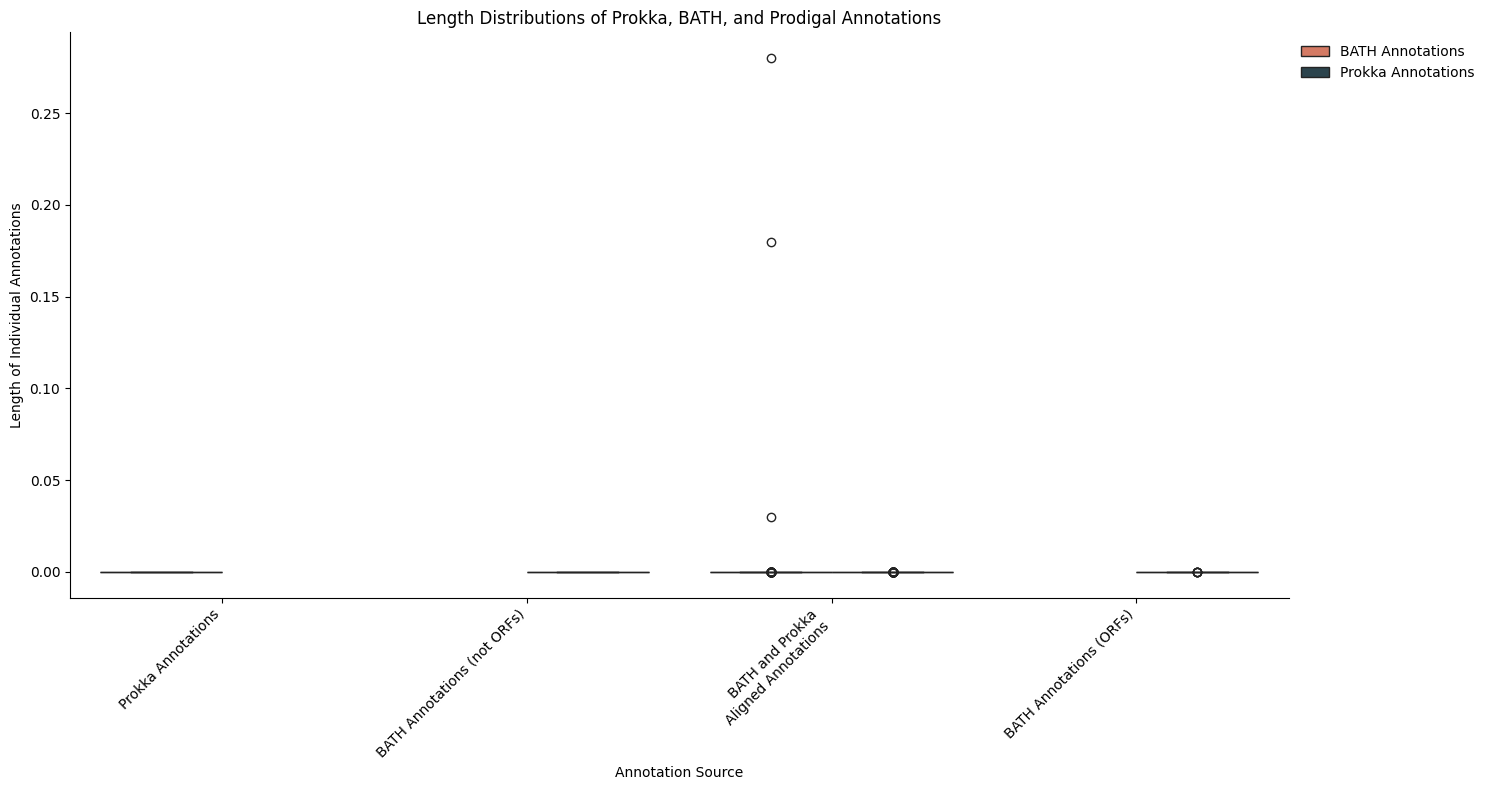

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the DataFrame for plotting
lengths = []
labels = []
annotations = []

# Populate the lists from the DataFrame
for _, row in df.iterrows():
    if pd.notna(row['E-value']):
        lengths.append(row['E-value'])
        labels.append(row['label'])
        annotations.append('Prokka')

    if pd.notna(row['merge_evalue']):
        lengths.append(row['merge_evalue'])
        labels.append(row['label'])
        annotations.append('BATH')


# Create a new DataFrame for plotting
plot_df = pd.DataFrame({
    'Length': lengths,
    'Label': labels,
    'Annotation': annotations
})

palette = {
    'Prokka': '#264653',
    'BATH': '#E76F51',
    'Prodigal ORF': '#E9C46A'
}

legend_labels = {
    'Prokka': 'Prokka Annotations',
    'BATH': 'BATH Annotations',
    'Prodigal ORF': 'Prodigal ORFs'
}
# Custom labels mapping
custom_labels = {
    'BATH and Prokka Annotated': 'BATH and Prokka\nAligned Annotations',
    'Prokka Unannotated': 'ORFs (Prodigal)',
    'BATH and Prokka Unannotated': 'BATH Annotations (ORFs)',
    'BATH': 'BATH Annotations (not ORFs)',
    'Unannotated': 'Unannotated',
    'Prokka Annotated':'Prokka Annotations'
}

# Apply custom labels to the dataframe for plotting
plot_df['Custom Label'] = plot_df['Label'].map(custom_labels)

plt.style.use('default')
fig, ax = plt.subplots(figsize=(15, 8))

# Create the box plot
sns.boxplot(x='Custom Label', y='Length', hue='Annotation', data=plot_df, palette=palette, ax=ax, width=0.8)

# Customize the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_title('Length Distributions of Prokka, BATH, and Prodigal Annotations')
ax.set_xlabel('Annotation Source')
ax.set_ylabel('Length of Individual Annotations')
ax.set_xticklabels([custom_labels.get(label, label) for label in plot_df['Custom Label'].unique()], rotation=45, ha='right')

# Adjust the legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [legend_labels[label] for label in labels]
ax.legend(handles, new_labels, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
plt.savefig("zFig4_length_ORFBATHProkka.svg", dpi=300, transparent=True, bbox_inches='tight')
plt.show()